In [1]:
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
from data.parliamentApiHelpers import ParliamentAPI
from data.generateJson import get_links
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

In [5]:
coalition = "XIV"
data_folder = f"../coalition_{coalition}"

In [6]:
df_votes = pd.read_parquet(f"{data_folder}/votes.parquet")
df_voters = pd.read_parquet(f"{data_folder}/voters.parquet")
df_vote_metadata = pd.read_parquet(f"{data_folder}/metadata.parquet")

In [7]:
df_vote_metadata = df_vote_metadata[(df_vote_metadata.date < "2023-03-05")]
df_votes = df_votes.loc[df_vote_metadata.index]
voter_id_to_name = df_voters["name"].to_dict()

In [8]:
adj_matrix = ParliamentAPI.generate_adjacency_matrix(df_votes, "jaccards", ["POOLT", "VASTU", "ERAPOOLETU"])

In [9]:
df_fractions = pd.read_parquet("../fractions.parquet")
df_fractions = df_fractions[df_fractions.shortName.notna()]
e200_id = "e4bf6970-f928-4230-961c-615cc54118f9"
df_fractions.loc[e200_id, "colorHex"] = "#008080"

In [10]:
def merge_components(components, source, target):
    source_c =  set([c for c in components if source in c][0])
    target_c = [c for c in components if target in c][0]
    remaining_component = [c for c in components if c != source_c and c!= target_c]
    new_c = source_c.union(target_c)
    remaining_component.append(new_c)
    return remaining_component, new_c
df_links = get_links(adj_matrix).sort_values(by="value", ascending=False)
all_components = [set([a]) for a in set(df_links.source).intersection(set(df_links.target))]

In [11]:
n = 8
top_n_links = df_links.groupby("source").head(n)
top_n_links = top_n_links[top_n_links["value"] > .4]

In [12]:
# create tree skeleton, ensuring there is a fully connected component
new_links = []
i = 0
df_links_processing = df_links.copy()
while len(all_components) > 1:
    print(i, len(all_components))

    top_link = df_links_processing.iloc[0]
    source = top_link.source
    target = top_link.target
    value = top_link.value
    print(f"{voter_id_to_name[source]}:{voter_id_to_name[target]}:{value}")
    new_links.append(top_link)
    # merge source and value
    all_components, created_component = merge_components(all_components, source, target)
    # filter df_links_processing so that source and target cannot be both in the created component
    cycle_created = (df_links_processing.source.isin(created_component) & df_links_processing.target.isin(created_component))
    df_links_processing = df_links_processing[~cycle_created].sort_values(by="value", ascending=False)

    i+=1
new_links = pd.DataFrame(new_links)
new_links = new_links[new_links["value"] > 0]

0 134
Aivar Viidik:Tiiu Aro:0.8820754716981132
1 133
Urve Tiidus:Andrus Seeme:0.8764988009592326
2 132
Toomas Järveoja:Sulev Kannimäe:0.8618968386023295
3 131
Urve Tiidus:Aivar Sõerd:0.8585798816568048
4 130
Kai Rimmel:Urmas Espenberg:0.8458574181117534
5 129
Sulev Kannimäe:Timo Suslov:0.8340214698596201
6 128
Marko Torm:Timo Suslov:0.833916083916084
7 127
Jüri Jaanson:Urve Tiidus:0.8273423688862699
8 126
Urve Tiidus:Kristina Šmigun-Vähi:0.8254156769596199
9 125
Toomas Jürgenstein:Reili Rand:0.8243626062322946
10 124
Marika Tuus-Laul:Natalia Malleus:0.8166563082660038
11 123
Riho Breivel:Uno Kaskpeit:0.8109875735775016
12 122
Kersti Sarapuu:Natalia Malleus:0.8106765983860956
13 121
Natalia Malleus:Jaanus Karilaid:0.8098720292504571
14 120
Uno Kaskpeit:Merry Aart:0.8070291777188329
15 119
Kaja Kallas:Signe Riisalo:0.8066666666666666
16 118
Maris Lauri:Andres Sutt:0.8052434456928839
17 117
Signe Kivi:Urve Tiidus:0.8051713770294648
18 116
Natalia Malleus:Marek Jürgenson:0.8026634382566586

In [13]:
# add top n on top of new_links skeleton
new_links = pd.concat([new_links, top_n_links]).drop_duplicates()

In [14]:
G = nx.from_pandas_edgelist(new_links, source="source", target="target", edge_attr=True)

In [15]:
name_to_color = {df_voters.loc[node]["name"]: df_fractions.loc[df_voters.loc[node]["factionId"]]["colorHex"] for node in G.nodes()}

In [16]:
color = [df_fractions.loc[df_voters.loc[node]["factionId"]]["colorHex"] for node in G.nodes()]

In [32]:
len(G.edges)

638

In [17]:
pd.Series({voter_id_to_name[k]:v for k,v in dict(G.degree()).items()}).sort_values(ascending=False)

Urve Tiidus             25
Andrus Seeme            25
Aivar Sõerd             24
Natalia Malleus         22
Kristina Šmigun-Vähi    21
                        ..
Reili Rand               1
Jevgeni Ossinovski       1
Ülle Rajasalu            1
Marina Kaljurand         1
Jüri Luik                1
Length: 134, dtype: int64

In [18]:
edge_colors = [(0, 0, 0, v**3) for v in new_links.value]

In [29]:
df_centrality = (pd.Series(dict(nx.centrality.current_flow_betweenness_centrality(G)))
                 .dropna()
                 .rename("current_flow_betweenness_centrality")
                 .rename(index=voter_id_to_name)
                 .sort_values(ascending=True)
                 )
df_centrality = pd.DataFrame(df_centrality).assign(
    color=df_centrality.index.map(name_to_color)
)
name_to_centrality = df_centrality["current_flow_betweenness_centrality"].sort_values(ascending=False).to_dict()

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


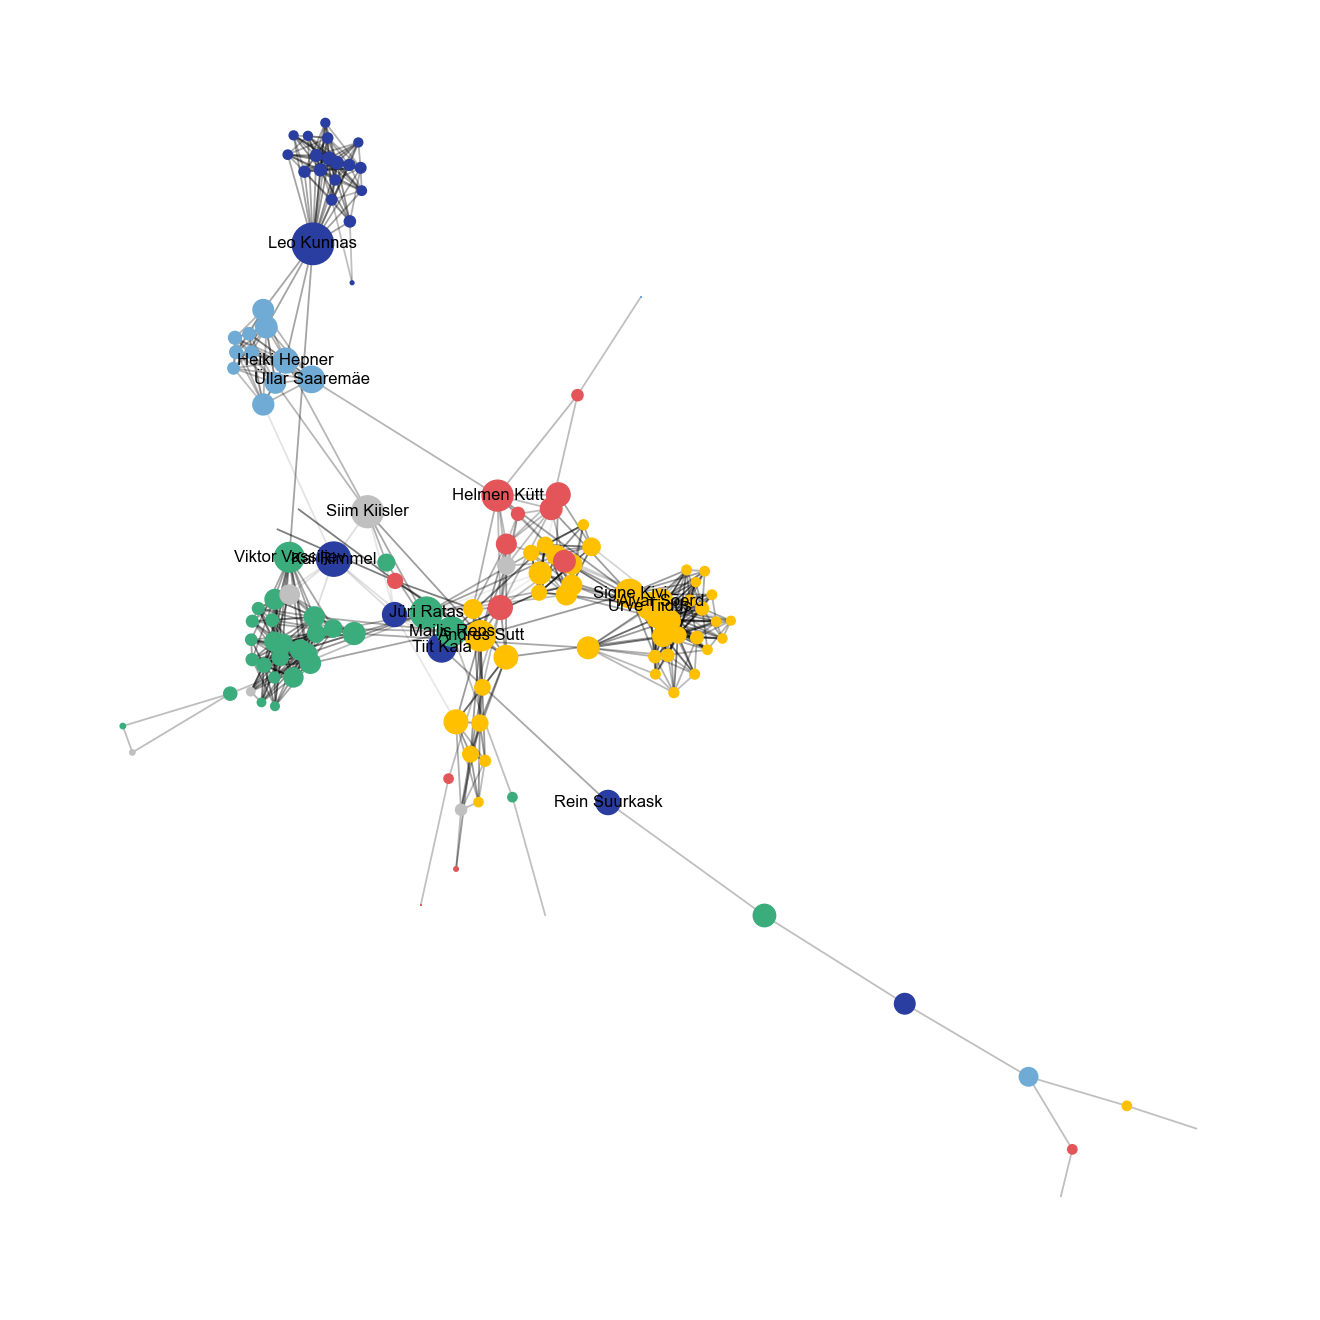

In [30]:
plt.rcParams['figure.figsize'] = [13, 13]
nx.draw(G,
        node_color=color,
        width=1.3,#new_links.value*4,
        edge_color=edge_colors,
        labels={k:v for k,v in voter_id_to_name.items() if ((k in new_links.source.values or k in new_links.target.values) and name_to_centrality[v] > .1)},
        node_size=3000*np.array(list(nx.centrality.current_flow_betweenness_centrality(G).values()))
        )

<BarContainer object of 134 artists>

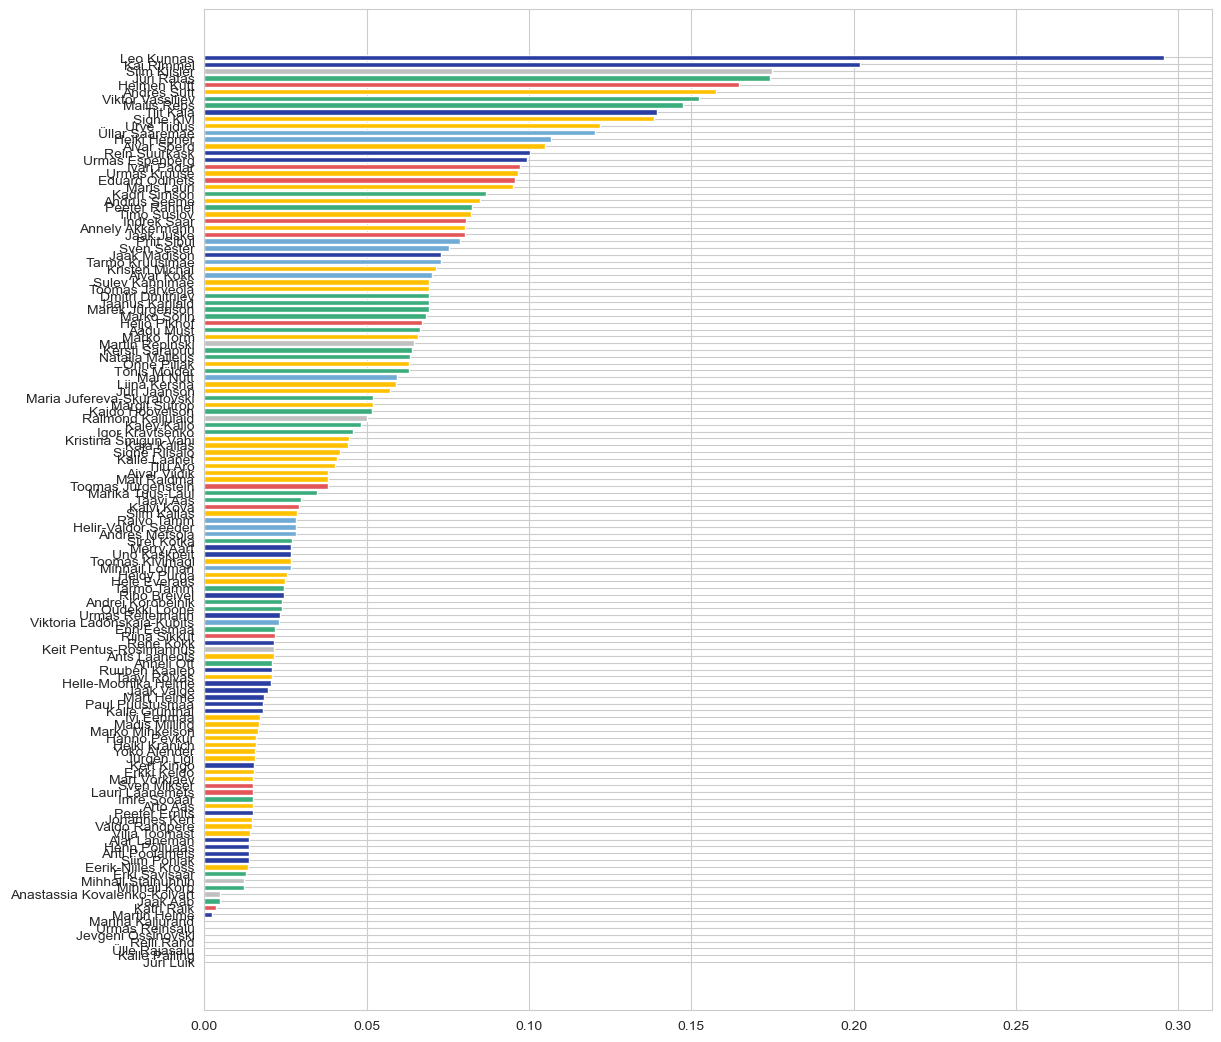

In [22]:
plt.barh(df_centrality.index, df_centrality["current_flow_betweenness_centrality"], color=df_centrality["color"])